# Практическая работа 1. Работу выполнил: Моложавенко Александр Александрович
## Импортирование библиотек

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from typing import List
from tqdm import tqdm

In [2]:
plt.rcParams['figure.figsize'] = 11, 7
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 16

## а) Фотокарточки

In [3]:
pic_paths = ["pic/" + str(i + 1) + ".jpg" for i in range(5)]
back_path = "pic/back.jpg"

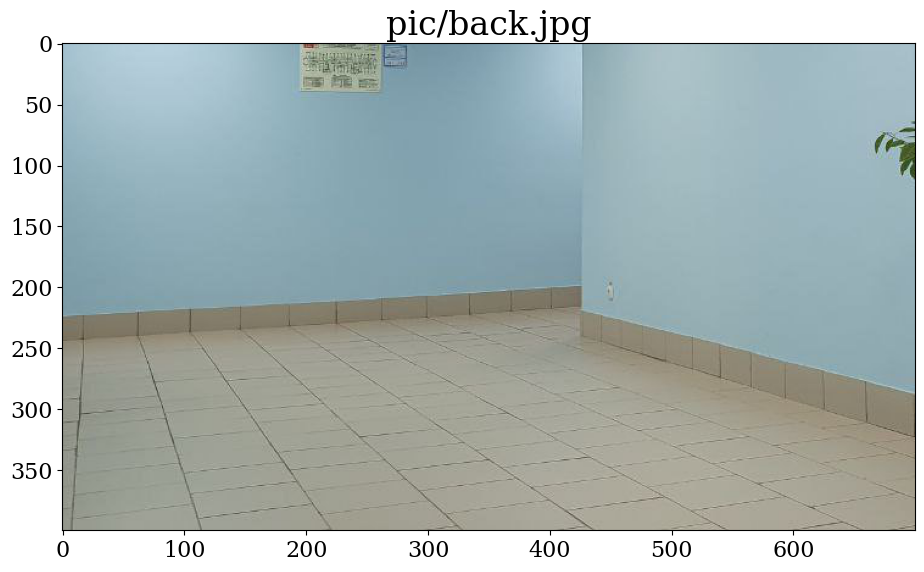

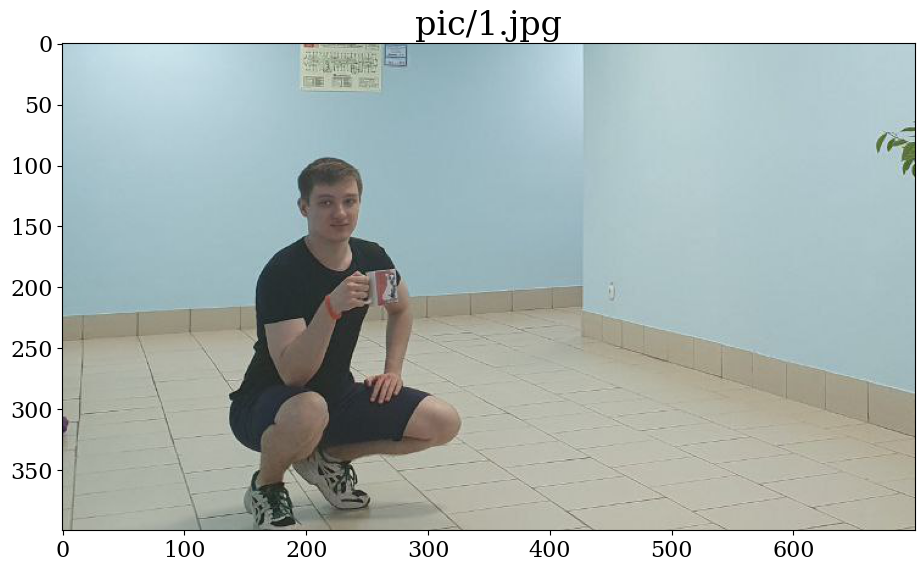

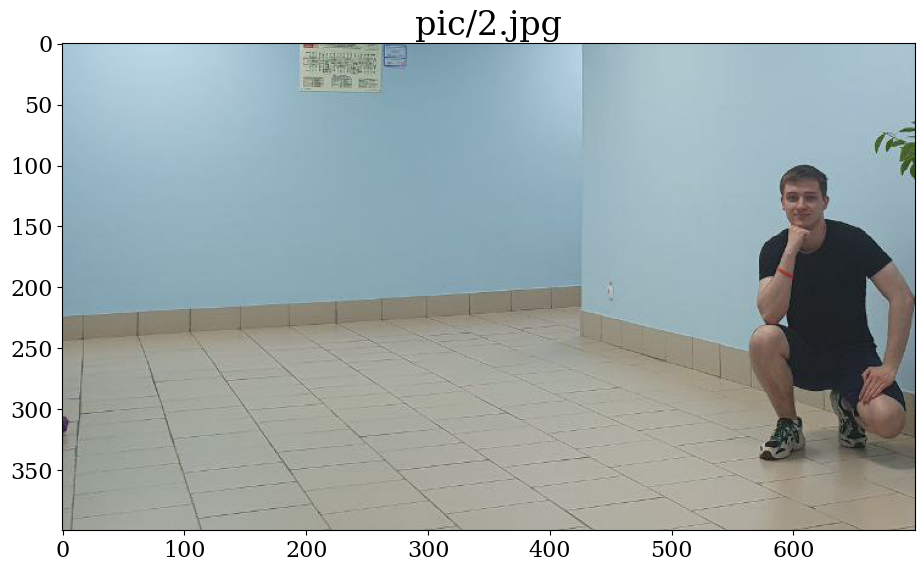

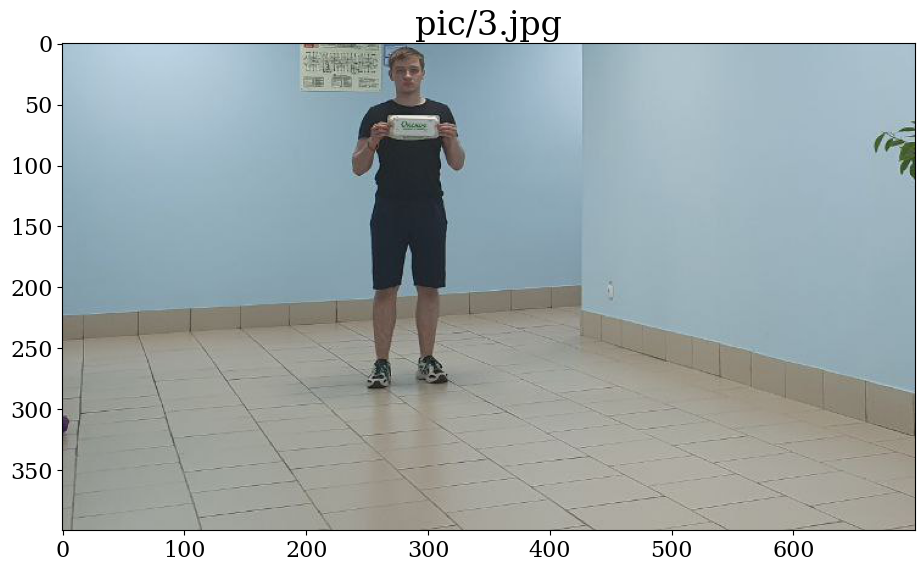

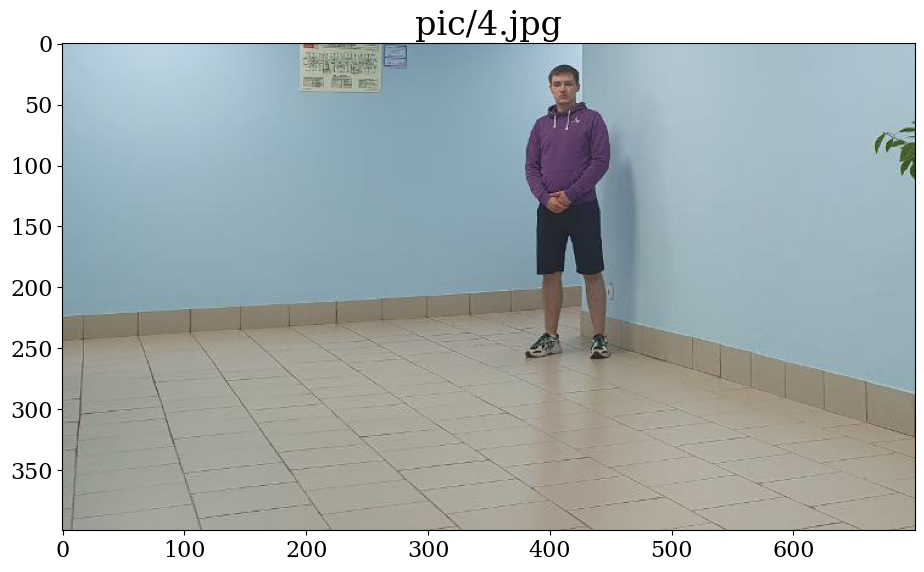

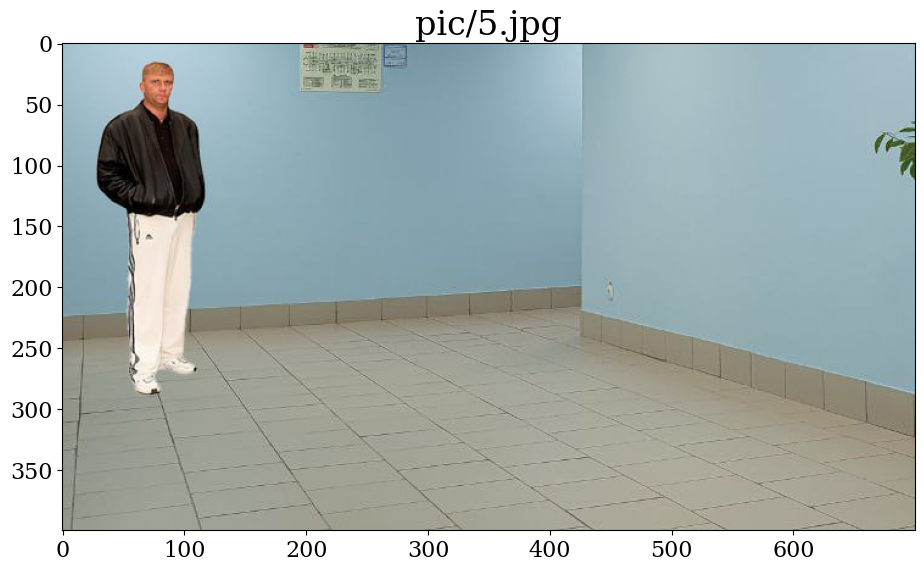

In [4]:
plt.imshow(plt.imread(back_path)[320:, 100:800, :])
plt.title(back_path)
plt.show()

for pic_path in pic_paths:
    plt.imshow(plt.imread(pic_path)[320:, 100:800, :])
    plt.title(pic_path)
    plt.show()

## б) Коллаж из $K = 2$ изображений

$$
E(\mathbf{x}) = \theta_0 + \sum_i \theta_i(x_i) + \sum_{(i, j)\in \varepsilon} \theta_{ij}(x_i, x_j)
$$

- **Система соседства**:
  для картинки с коодинатами $(k, l)$: соседи $\{(k - 1, l - 1), (k - 1, l), (k - 1, l + 1), (k, l - 1), (k, l + 1), (k + 1, l - 1), (k + 1, l), (k + 1, l + 1)\}$, если каких-то координат не существует, то они попросту не добавляются. Иными словами у элементов с границы соседей меньше.
  
- **Вид унитарных потенциалов**:
  $\theta_i (x_i) = 0$, кроме особенных пикселей, значение в которых равно бесконечности, то есть в этиъх пикселях мы провоцируем алгоритм выбирать противоположную картину.
  
- **Вид парных потенциалов**:
  $$
  \theta_{ij}(x_i, x_j) = [x_i \neq x_j] \cdot J(i ,j),
  $$
  
  $$
  J(i, j) = \begin{cases}100, \|y[0]_i - y[1]_j\|^2_1 > \|y[1]_i - y[1]_j\|_1 \cdot \|y[0]_i - y[0]_j\|_1 \\ 50, \text{else} \end{cases}
  $$
  
  где $x_i$ - метка того, к какому изображению принадлежит пиксель с номером $i$, а $y[k]_i$ - вектор из трех чисел  (цвета соответствующего пикселя в картинке $k \in \{0, 1\}$)
  

**Выбранные потенциалы отражают цель построить правдоподобный для человеческого глаза коллаж** следующим образом: унарные потенциалы провоцируют алгоритм выбирать определенные части различных картинок (с помощью бесконечных потенциалов). Далее в дело включаются парные потенциалы: если сосед выбранного пикселя с той же картинки, что и он сам, то ничего не меняется. Иначе мы считаем квадрат нормы разницы RGB векторов пикселей с разных картинок. Если разница больше, чем произвдение норм разницы RGB векторов пикселей с одинаковых картинок, то потенциал равен $100$, а иначе $50$. Тем самым мы охотнее выбираем те ребра, в которых переход плавнее, что провоцирует алгоритм достраивать островки, помеченные бесконечностью.

**Чтобы указать, что некоторые части коллажа стоит брать из определенного изображения,** унарные потенциалы в пикселях этих частей выберем так, чтобы их значение на противоположной картинке равнялось $+\infty$. То есть, если я хочу, чтобы пиксель с номером $i$ был из изображения номер ноль, то я определю $\theta_i(1) := +\infty, \theta_i(0) < +\infty$, тогда алгоритму ничего не останется, кроме того как выбрать картинку номер ноль для определения пикселя с номером $i$.


**Функция энергии $E(\mathbf{x}$) связана с вероятностью появления коллажа $p(\mathbf{x})$** следующим образом: $E(\mathbf{x}) \to \min\limits_{\mathbf{x}}$, то есть вероятность выбрать конкретную конфигурацию $\mathbf{x}$ пропорциональна вероятности оптимизационного алгоритма в качестве $\arg\min$ задачи выбрать $\mathbf{x}$:

$$
\log p(\mathbf{x}) \propto -E(\mathbf{x})
$$


## в) Субмодулярность потенциалов:

**Определение** Потенциалы называются субмодулярными, если преобладают недиагональные элементы:

$$
\theta_{ij}(0, 1) + \theta_{ij}(1, 0) \geqslant \theta_{ij}(0, 0) + \theta_{ij}(1, 1)
$$

В нашем случае:

$$
\theta_{ij}(0, 1) + \theta_{ij}(1, 0) \geqslant \theta_{ij}(0, 0) + \theta_{ij}(1, 1) = 0
$$

В силу того, что: 

$$
\theta_{ij}(0, 1) \geqslant 0,  \theta_{ij}(1, 0) \geqslant 0
$$


Имеем, что  выбранные потенциалы являются субмодулярными по определению.

## Эксперимент

In [5]:
pics = []
pics.append(plt.imread(pic_paths[4])[320:, 100:800, :])
pics.append(plt.imread(pic_paths[3])[320:, 100:800, :])

In [6]:
def get_neighbours(X: np.ndarray, coords: tuple[int, int], neighbour_type: str = 'square', custom_mask: List[tuple] = None) -> List[tuple]:
    
    if len(X.shape) > 2:
        raise ValueError(f'X should be matrix, but got X shape = {X.shape}')
        
    square_mask = [(-1, -1), (-1, 0), (-1, 1), 
                    (0, -1),           (0, 1), 
                    (1, -1),  (1, 0),  (1, 1)]
    
    сross_mask = [        (-1, 0),  
                  (0, -1),        (0, 1), 
                          (1, 0),        ]
    
    if neighbour_type == 'square':
        mask = square_mask
    elif neighbour_type == 'cross':
        mask = сross_mask
    elif neighbour_type == 'custom':
        mask = custom_mask
    else:        raise NotImplementedError(f'neighbour_type: {neighbour_type} does not exist!')
        
    neighbours = []
    X_h, X_w = X.shape
    h, w = coords

    for elem in mask:
        elem_h, elem_w = elem
        if 0 <= h + elem_h < X_h and 0 <= w + elem_w < X_w:
            neighbours.append((h + elem_h, w + elem_w))
        
    return neighbours

def test_get_neighbours(X: np.ndarray = None, **get_neighbours_kwargs):
    if X is None:
        X = np.arange(25).reshape(5, 5)
    print('Curren X:')
    print(X)
    for x in range(X.shape[0]):
        for y in range(X.shape[1]):
            nei = get_neighbours(X, (x, y), **get_neighbours_kwargs)
            X_nei = []
            for n in nei:
                X_nei.append(X[n])

            print(f'For {x, y}: {X_nei}')

In [7]:
def unary(x1: int, pics: List[np.ndarray], coords: tuple[int, int], seed: tuple[tuple], antiseed: tuple[tuple]):
    if seed[0][0] <= coords[0] <= seed[0][1] and seed[1][0] <= coords[1] <= seed[1][1] and x1 == 1:
        return np.inf
    elif antiseed[0][0] <= coords[0] <= antiseed[0][1] and antiseed[1][0] <= coords[1] <= antiseed[1][1] and x1 == 0:
        return np.inf
    else:
        return 0

def binary(x1: int, x2: int, pics: List[np.ndarray], coords1: tuple[int, int], coords2: tuple[int, int], sigma: float = 1.0):
    if x1 == x2:
        return 0
    else:
        if np.linalg.norm(pics[x1][coords1] - pics[x2][coords2], ord=1) ** 2 > ((np.linalg.norm(pics[x1][coords1] - pics[x1][coords2], ord=1) * np.linalg.norm(pics[x2][coords1] - pics[x2][coords2], ord=1))):
            return 100
        else:
            return 50

In [8]:
def build_pic_di_graph(X: np.ndarray, pics: List[np.ndarray], seed: tuple[tuple], antiseed: tuple[tuple]) -> tuple[List]:
    # create node s and draw weighted edges from s to every element of X
    # create node t and draw weighted edges from every element of X to t
    # for every element of X:
    #   compute its neighbours 
    #   compute the weight of connection and connect it to neighbours
    nodes = []
    for x in range(X.shape[0]):
        for y in range(X.shape[1]):
            nodes.append((x, y))

    DG = nx.DiGraph()
    DG.add_nodes_from(['s'] + nodes + ['t'])
    for node in tqdm(nodes):
        DG.add_edge('s', node, capacity=unary(1, pics, node, seed, antiseed))
        DG.add_edge(node, 't', capacity=unary(0, pics, node, seed, antiseed))

    for node in tqdm(nodes):
        node_neighs = get_neighbours(X, node)
        for neigh in node_neighs:
            DG.add_edge(node, neigh, capacity=binary(1, 0, pics, node, neigh))
    
    return DG, nodes

In [9]:
X = np.ones(pics[0].shape[:-1])
seed = ((150, 250), (150, 250))
antiseed =  ((150, 250), (550, 650))
DG, nodes = build_pic_di_graph(X, pics, seed, antiseed)

100%|██████████████████████████████████████████████████████████████████████████████| 280000/280000 [00:23<00:00, 11756.49it/s]


In [10]:
cut_val, partition = nx.minimum_cut(DG, 's', 't')
print(cut_val)
print(len(partition[0]), len(partition[1]))

71700
151806 128196


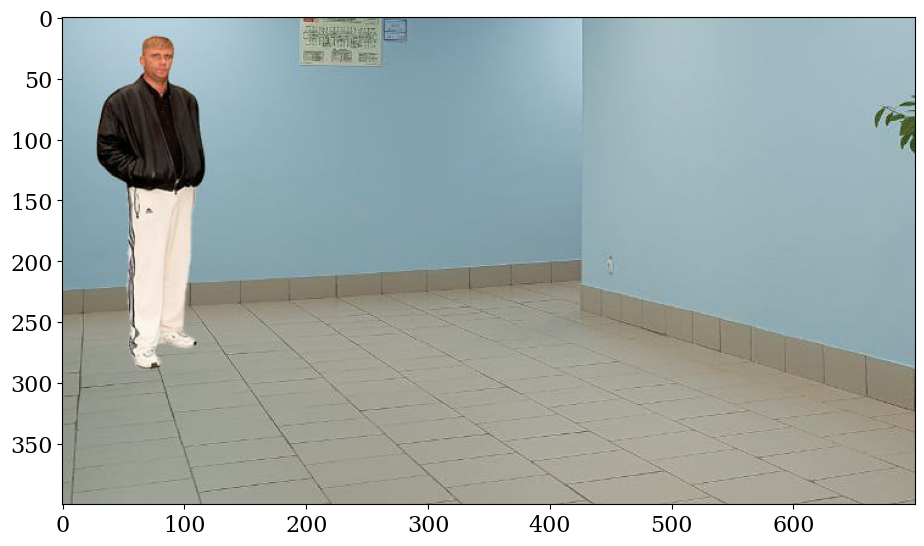

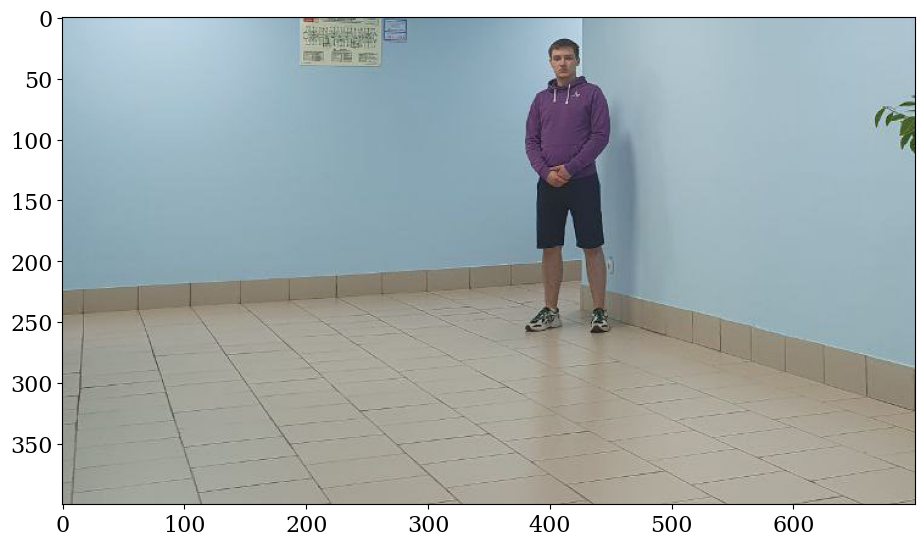

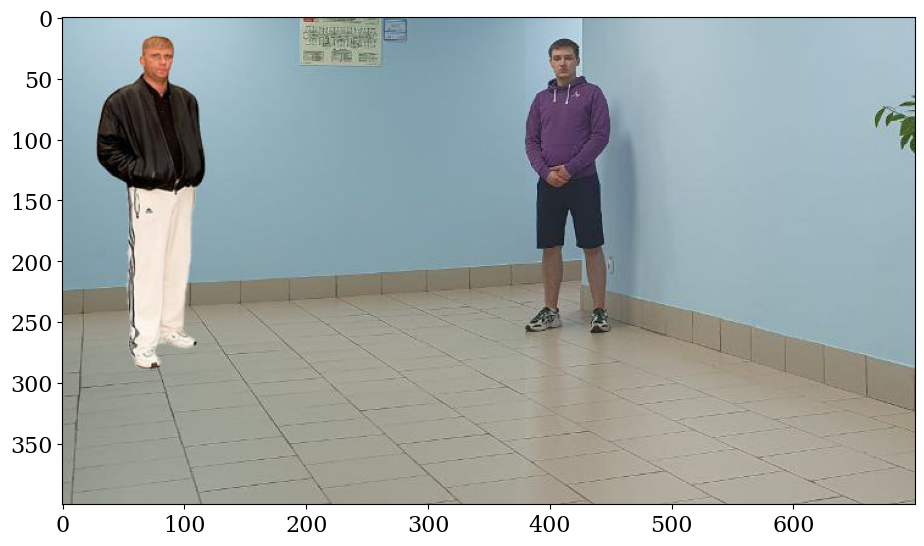

In [11]:
for pic in pics:
    plt.imshow(pic)
    plt.show()

restored_image = np.ones(pics[0].shape, dtype='uint8')
for i in range(2):
    for elem in partition[i]:
        if elem == 's' or elem == 't':
            continue
        restored_image[elem] = pics[i][elem].astype('uint8')    
        
plt.imshow(restored_image)
plt.show()

Коллаж я привёл выше, потенциалы много раз переписывались. Данные две фотографии выбраны поскольку цвет окружения на них примерно одинаков. Лампы в коридоре общежития очень странные и дают нестатичное освещение.

д) Мой потенциал подходит и для этого пункта